
# I Used the Twitter API to Build Mimetic Value's Social Network Graph

A graph is a technique used by mathematicians and others to visualize relationships among members of a group. The word "social" here has to do with social media, something that gets "follow each other" not just for the root, but also its 1st and 2nd degree connections.

Here I scrape twitter for screen names, the **Followed** (upstream), and **Followers** (downstream) links shown in the users homepage.


# Load the various utility libraries

This is written as if you were running the notebook within a clone of my notebooks repository from a Microsoft Windows operating system.

In [1]:

# Install the Twarc library
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install --upgrade Twarc --quiet

In [96]:

# Install the xmltodict library
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install xmltodict --upgrade --quiet

In [2]:

# Grab some storage utility functions using load magic
%run ../../load_magic/storage.py
%who

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/
DATA_FOLDER	 ENCODING_TYPE	 SAVES_FOLDER	 attempt_to_pickle	 load_csv	 load_dataframes	 load_object	 ngrams	 os	 
pd	 pickle	 save_dataframes	 store_objects	 



# Prepare the directional graph for adding nodes and edges to

In [48]:

from twarc import Twarc
import numpy as np
import networkx as nx
import re

mimetic_twarc = Twarc(config=r'C:\Users\dev\.twarc')
screen_name = 'MimeticValue'
user_id = '971039581406748672'
mimetic_following_set = set(mimetic_twarc.friend_ids(user_id))
print('{} is following {} others.'.format(screen_name, len(mimetic_following_set)))
mimetic_followers_set = set(mimetic_twarc.follower_ids(user_id))
print('{} has {} followers.'.format(screen_name, len(mimetic_followers_set)))

mimetic_digraph = nx.DiGraph()
node_list = [user_id]
mimetic_digraph.add_node(user_id)
pos_dict = {}

MimeticValue is following 327 others.
MimeticValue has 5871 followers.


This code in the cell below is just a hack to force networkx to distribute the nodes in a random way across 100 slots so as not to write the labels on top of one another.

In [79]:

from random import shuffle

y_supply = list(range(100))
shuffle(y_supply)

def y():
    
    return (y_supply.pop())

In [80]:

def build_graph(mimetic_digraph, user_id, mimetic_following_set, mimetic_followers_set, level):
    
    for influences_id in mimetic_following_set:
        if influences_id not in node_list:
            mimetic_digraph.add_node(influences_id)
        mimetic_digraph.add_edge(influences_id, user_id)
        if influences_id not in node_list:
            if level < 2:
                level += 1
                influences_following_set = set(mimetic_twarc.friend_ids(influences_id))
                influences_followers_set = set(mimetic_twarc.follower_ids(influences_id))
                mimetic_digraph = build_graph(mimetic_digraph, influences_id, influences_following_set,
                                              influences_followers_set, level)
            node_list.append(influences_id)
    
    for influenced_id in mimetic_followers_set:
        if influenced_id not in node_list:
            mimetic_digraph.add_node(influenced_id)
        mimetic_digraph.add_edge(user_id, influenced_id)
        if influenced_id not in node_list:
            if level < 2:
                level += 1
                influenced_following_set = set(mimetic_twarc.friend_ids(influenced_id))
                influenced_followers_set = set(mimetic_twarc.follower_ids(influenced_id))
                mimetic_digraph = build_graph(mimetic_digraph, influenced_id, influenced_following_set,
                                              influenced_followers_set, level)
            node_list.append(influenced_id)
    
    return mimetic_digraph


# Add the nodes and edges

And store the graph as a pickle so I don't have to keep on recreating it.

In [81]:

mimetic_digraph = build_graph(mimetic_digraph, user_id, mimetic_following_set, mimetic_followers_set, level=0)
store_objects(mimetic_digraph=mimetic_digraph)

Pickling to ../saves/pickle/mimetic_digraph.pickle


In [82]:

# trim the nodes that don't form triangles
mimetic_digraph = load_object('mimetic_digraph')
degree_view = list(mimetic_digraph.degree())
for node, degree in degree_view:
    if degree < 2:
        mimetic_digraph.remove_node(node)
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/mimetic_digraph.gexf')

In [83]:

import collections

degree_sequence = sorted([d for n, d in mimetic_digraph.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
degree_tuple, count_tuple = zip(*degreeCount.items())
print(degree_tuple, count_tuple)

(982, 883, 745, 711, 6, 5, 4, 3, 2) (1, 1, 1, 1, 2, 3, 21, 140, 1392)


In [86]:

# Let's look at Mimetic's profile
for lookup_dict in mimetic_twarc.user_lookup([screen_name], id_type='screen_name'):
    for key, value in lookup_dict.items():
        print('{}: {}'.format(key, value))
    print()
    print()

id: 971039581406748672
id_str: 971039581406748672
name: Mimetic Value
screen_name: MimeticValue
location: exponential growth curve
description: Being-towards-co(s)mic-horror. Interdisciplinary theory of value: nonergodicity in myths, sacrifice, desire, fitness, zen, networks, anomalies & innovation
url: https://t.co/n22FNSBE50
entities: {'url': {'urls': [{'url': 'https://t.co/n22FNSBE50', 'expanded_url': 'http://mimeticarbitrage.com/Value%20Mythology.pdf', 'display_url': 'mimeticarbitrage.com/Value%20Mythol…', 'indices': [0, 23]}]}, 'description': {'urls': []}}
protected: False
followers_count: 5340
friends_count: 294
listed_count: 88
created_at: Tue Mar 06 15:07:32 +0000 2018
favourites_count: 26999
utc_offset: None
time_zone: None
geo_enabled: False
verified: False
statuses_count: 9184
lang: en
status: {'created_at': 'Sun Jul 29 01:16:29 +0000 2018', 'id': 1023376683817160709, 'id_str': '1023376683817160709', 'full_text': '@MatthausAnsatz @cognazor The problem with IDW is that they p


# Use the Gephi layout

It turns out it is hard to create a visualization that lets you see each node an edge. So I imported the graph into Gephi.

In [138]:

# Export the graph into Gephi
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')


Next, I ran the Expansion, Force Atlas, Fruchterman Feingold, Yifan Hu, and Rotate layouts until I got a nice looking graph. Then I exported the Graph file as a GEXF.

In [11]:

import xmltodict

with open(SAVES_FOLDER+'gexf/post_gephi_mimetic_digraph.gexf', 'r') as fid:
    mimetic_xml = fid.read()
mimetic_tree = xmltodict.parse(mimetic_xml)

In [12]:

import numpy as np

# Get the position dictionary from the GEXF saved from Gephi
node_dict_list = mimetic_tree['gexf']['graph']['nodes']['node']
pos_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                       float(node_dict['viz:position']['@y'])]) for node_dict in node_dict_list}

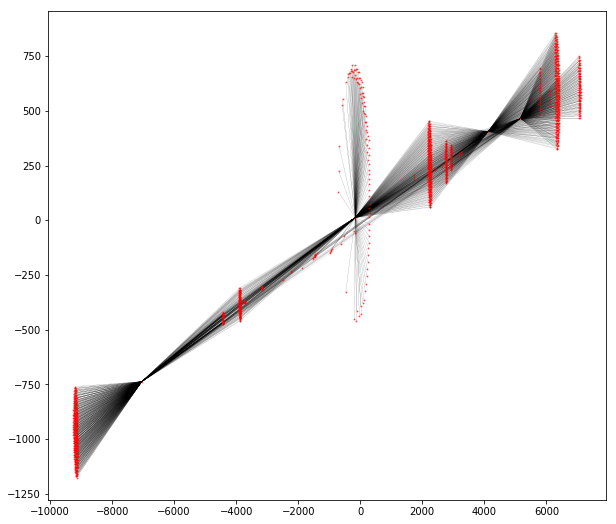

In [13]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Draw the graph using the default spring layout
mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')
plt.figure(figsize=(10,9))
node_collection = nx.draw_networkx_nodes(G=mimetic_digraph, pos=pos_dict, alpha=0.5, node_size=1)
edge_collection = nx.draw_networkx_edges(G=mimetic_digraph, pos=pos_dict, alpha=0.5, width=0.1, arrows=False)
#labels_collection = nx.draw_networkx_labels(G=mimetic_digraph, pos=pos_dict, font_size=14)

In [8]:

store_objects(mimetic_pos_dict=pos_dict)

Pickling to ../saves/pickle/mimetic_pos_dict.pickle



# Categorize the users by a cluster analysis of the node positions

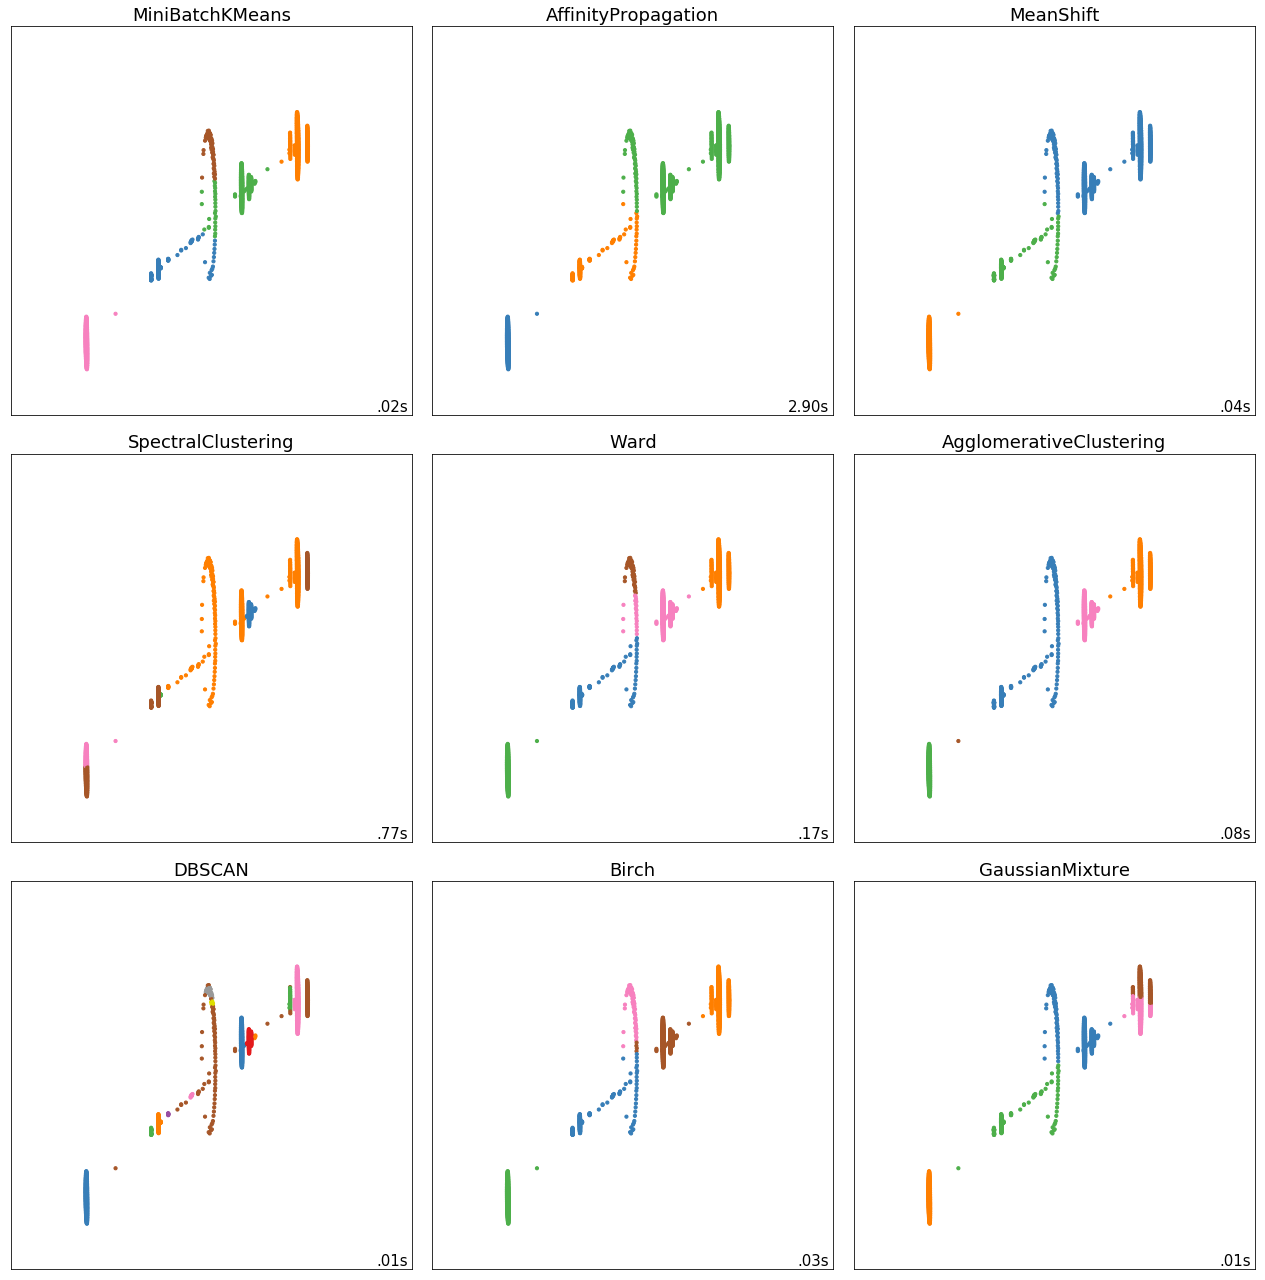

In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
import time
import warnings
from itertools import cycle, islice

plt.figure(figsize=(18, 18))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.1)
plot_num = 1
params = {'quantile': .3, 'eps': .03, 'damping': .9, 'preference': -200,
          'n_neighbors': 10, 'n_clusters': 5, 'threshold': 0.4}

X = np.array([np.array([float(node_dict['viz:position']['@x']),
                        float(node_dict['viz:position']['@y'])]) for node_dict in node_dict_list])

# Normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'],
                                include_self=False)
# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'],
                                       linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'],
                                      eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(damping=params['damping'],
                                                   preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",
                                                  n_clusters=params['n_clusters'],
                                                  connectivity=connectivity)
birch = cluster.Birch(threshold=params['threshold'], branching_factor=50,
                      n_clusters=params['n_clusters'], compute_labels=True, copy=True)
gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)
label_dict = {}

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    label_dict[name] = y_pred

    plt.subplot(3, 3, plot_num)
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1


It looks like DBSCAN is the most interesting. Let's extract its labels and use their groupings to figure out the tf-idfs.


# Label the users by an n-gram tf-idf of their tweets

In [11]:

import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from nltk import sent_tokenize

url_regex = re.compile(r"\b(?:(?:https?|ftp|file)://|www\.|ftp\.)[-A-Z0-9+&@#/%=~_|$?!:,.]*[A-Z0-9+&@#/%=~_|$]", re.IGNORECASE)
ellipse_regex = re.compile(r"\s+\xa0…")
username_regex = re.compile(r"@\w{1,15}\b")

def clean_tweets_list(tweets_list):
    user_sentences_list = []
    for tweets_str in tweets_list:
        tweets_str = url_regex.sub('', tweets_str)
        tweets_str = ellipse_regex.sub('', tweets_str)
        tweets_str = username_regex.sub('', tweets_str)
        sentences_list = sent_tokenize(tweets_str)
        for sentence in sentences_list:
            user_sentences_list.append(sentence)
    
    return user_sentences_list

In [12]:

from nltk.tokenize import word_tokenize

table_dict = str.maketrans('', '', string.punctuation)
porter = PorterStemmer()
stop_words_list = ['rt', 'btc', 'eth', 'jpi', 'lt']
for lang_str in ['english', 'spanish', 'arabic']:
    stop_words_list.extend(stopwords.words(lang_str))
stop_words_set = set(stop_words_list)

def clean_sentences_list(sentences_list):
    stemmed_list_list = []
    for sentence_str in sentences_list:
        tokens_list = word_tokenize(sentence_str)

        # Remove punctuation from each word
        stripped_list = [w.translate(table_dict) for w in tokens_list]

        # Remove all tokens that are not alphabetic and lower-case them
        words_list = [word.lower() for word in stripped_list if word.isalpha()]

        # Filter out stop words
        words_list = [w for w in words_list if not w in stop_words_set]

        # Stemming of words
        stemmed_list = [porter.stem(word) for word in words_list]

        stemmed_list_list.append(stemmed_list)
    
    return stemmed_list_list

In [68]:

import networkx as nx
from twarc import Twarc

mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')
mimetic_twarc = Twarc(config=r'C:\Users\dev\.twarc')
user_name_dict = {}
user_stemmed_list_list_dict = {}
for node in mimetic_digraph.nodes():
    try:
        lookup_dict_list = mimetic_twarc.user_lookup([node])
        for lookup_dict in lookup_dict_list:
            user_name = lookup_dict['name']
            user_name_dict[node] = user_name
            tweets_list = []
            for tweet_dict in mimetic_twarc.search(node):
                tweets_list.append(tweet_dict['full_text'])
            user_sentences_list = clean_tweets_list(tweets_list)
            user_stemmed_list_list = clean_sentences_list(user_sentences_list)
            user_stemmed_list_list_dict[node] = user_stemmed_list_list
    except Exception as e:
        print(e)
store_objects(user_name_dict=user_name_dict, user_stemmed_list_list_dict=user_stemmed_list_list_dict)

404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=414979077&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=191584944&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=15454871&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=1633521084&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=4925261147&tweet_mode=extended
Pickling to ../saves/pickle/user_name_dict.pickle
Pickling to ../saves/pickle/user_stemmed_list_list_dict.pickle


In [3]:

from nltk import ngrams

user_stemmed_list_list_dict = load_object('user_stemmed_list_list_dict')
user_ngrams_statistics = {}
for n in range(2, 0, -1):
    for user_id, user_stemmed_list_list in user_stemmed_list_list_dict.items():
        for stemmed_list in user_stemmed_list_list:
            ngrams_generator = ngrams(stemmed_list, n)
            for ngram in ngrams_generator:
                if ngram in user_ngrams_statistics.keys():
                    ngram_occurrences = user_ngrams_statistics[ngram]
                    user_ngrams_statistics.update({ngram:ngram_occurrences+1})
                else:
                    user_ngrams_statistics.update({ngram:1})
user_ngrams_statistics_sorted = sorted(user_ngrams_statistics.items(), reverse=True, key=lambda x: x[1])
ngrams_statistics_blank = [(x[0], 0) for x in user_ngrams_statistics_sorted]

C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


In [4]:

# "برنامج" apparently means "a program", so I don't think that's a stop word
user_ngrams_statistics_sorted[0:3]

[(('あなたのことが好きな年齢層',), 518), (('love',), 53), (('japan',), 51)]

In [5]:

# Get the statistics for a particular user
def get_id_ngrams_statistics(stemmed_list_list, n_range):
    id_ngrams_statistics = {x[0]: x[1] for x in ngrams_statistics_blank}
    for stemmed_list in stemmed_list_list:
        for n in n_range:
            ngrams_generator = ngrams(stemmed_list, n)
            for ngram in ngrams_generator:
                if ngram in id_ngrams_statistics.keys():
                    ngram_occurrences = id_ngrams_statistics[ngram]
                    id_ngrams_statistics.update({ngram:ngram_occurrences+1})
    
    return id_ngrams_statistics

In [15]:

import numpy as np

label_user_id_dict = {}
for label in np.unique(label_dict['DBSCAN']):
    label_user_id_dict[label] = []
for (user_id, pos_array), label in zip(pos_dict.items(), label_dict['DBSCAN']):
    user_id_list = label_user_id_dict[label]
    user_id_list.append(user_id)
    label_user_id_dict[label] = user_id_list

In [16]:

label_stemmed_list_list_dict = {}
for label, user_id_list in label_user_id_dict.items():
    label_stemmed_list_list = []
    for user_id in user_id_list:
        if user_id in user_stemmed_list_list_dict:
            user_stemmed_list_list = user_stemmed_list_list_dict[user_id]
            if len(user_stemmed_list_list) > 0:
                label_stemmed_list_list.extend(user_stemmed_list_list)
    label_stemmed_list_list_dict[label] = label_stemmed_list_list

In [17]:

label_id_ngrams_statistics_dict = {}
for label in np.unique(label_dict['DBSCAN']):
    stemmed_list_list = label_stemmed_list_list_dict[label]
    id_ngrams_statistics = get_id_ngrams_statistics(stemmed_list_list, range(2, 0, -1))
    label_id_ngrams_statistics_dict[label] = id_ngrams_statistics

C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: generator 'ngrams' raised StopIteration
  


In [18]:

def get_label_counts_tfidf():
    label_counts_list = []
    for label in np.unique(label_dict['DBSCAN']):
        stemmed_list_list = label_stemmed_list_list_dict[label]
        id_ngrams_statistics = label_id_ngrams_statistics_dict[label]
        label_counts_list.append([id_ngrams_statistics[x[0]] for x in ngrams_statistics_blank])

    counts_transformer = TfidfTransformer(smooth_idf=False)
    label_counts_tfidf = counts_transformer.fit_transform(label_counts_list)
    
    return label_counts_tfidf

In [19]:

from sklearn.feature_extraction.text import TfidfTransformer

for label, sparse_matrix in zip(np.unique(label_dict['DBSCAN']), get_label_counts_tfidf()):
    label_ngrams_statistics = {}
    for x, y in zip(ngrams_statistics_blank, list(sparse_matrix.toarray()[0])):
        label_ngrams_statistics[x[0]] = y
    ngram_list = []
    frequency_float_list = []
    for ngram in label_ngrams_statistics.keys():
        ngram_list.append(ngram)
        frequency_float_list.append(label_ngrams_statistics[ngram])
    tuple_tuple_list = sorted([(ngram, frequency_float) for ngram, frequency_float in zip(ngram_list, frequency_float_list)],
                              reverse=True, key=lambda x: x[1])[:4]
    search_str = '{} '.format(label)
    for tuple_tuple in tuple_tuple_list:
        ngram_tuple, frequency_float = tuple_tuple
        ngram_str = '({}) {:.3f} '.format(' '.join([stem_str for stem_str in ngram_tuple]), frequency_float)
        search_str += ngram_str
    print()
    print(search_str)


-1 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

0 (çocuklar imam) 0.263 (imam olmaktan) 0.263 (olmaktan vazgeçtil) 0.263 (imam) 0.263 

1 (best) 0.328 (gear) 0.328 (best women) 0.263 (women surf) 0.263 

2 (broto) 0.433 (पर theori) 0.217 (theori rel) 0.217 (sorta pra) 0.217 

3 (あなたのことが好きな年齢層) 0.996 (さんのことが好きな年齢層 あなたのことが好きな年齢層) 0.029 (さんのことが好きな年齢層) 0.029 (ﾟдﾟ) 0.012 

4 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

5 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

6 (older peopl) 0.271 (peopl less) 0.271 (less like) 0.271 (like recognis) 0.271 

7 (radiationinduc leiomyosarcoma) 0.302 (leiomyosarcoma rectum) 0.302 (rectum cervic) 0.302 (cervic cancer) 0.302 

8 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

9 (good morn) 0.187 (good) 0.187 (morn) 0.187 (vanderbilt offici) 0.156 

10 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

11 (あなたのことが好きな年齢層) 0.000 (love) 0.000 (japan) 0.000 (world) 0.000 

In [29]:

mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/capped_mimetic_digraph.gexf')
dbscan_dict = {}
for dbscan_label, user_id_list in label_user_id_dict.items():
    for user_id in user_id_list:
        dbscan_dict[str(user_id)] = float(dbscan_label)
nx.set_node_attributes(mimetic_digraph, dbscan_dict, name='dbscan')
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/dbscan_mimetic_digraph.gexf')

In [31]:

# Let's record every node's language as an attribute
from twarc import Twarc

mimetic_twarc = Twarc(config=r'C:\Users\dev\.twarc')
lang_dict = {}
for node in mimetic_digraph.nodes():
    try:
        lookup_dict_list = mimetic_twarc.user_lookup([node])
        for lookup_dict in lookup_dict_list:
            if 'id' in lookup_dict:
                user_id = lookup_dict['id']
                if 'lang' in lookup_dict:
                    lang_dict[str(user_id)] = lookup_dict['lang']
    except Exception as e:
        print(e)
nx.set_node_attributes(mimetic_digraph, lang_dict, name='lang')
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/lang_mimetic_digraph.gexf')

404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=191584944&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=15454871&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=1633521084&tweet_mode=extended


404 Client Error: Not Found for url: https://api.twitter.com/1.1/users/lookup.json?user_id=4925261147&tweet_mode=extended


In [56]:

user_stemmed_list_list_dict = load_object('user_stemmed_list_list_dict')
remark_str = 'There are {} users in Memetic Value\'s social network that don\'t even produce tweets when I use the API!'
zero_list = [user_id for user_id, stemmed_list_list in user_stemmed_list_list_dict.items() if len(stemmed_list_list) == 0]
print(remark_str.format(len(remark_str)))

There are 103 users in Memetic Value's social network that don't even produce tweets when I use the API!


In [36]:

import twitter_scraper
import anaconda_navigator
import botocore
import botometer
import examples
import gensim
import nltk
import pandas
import pip
import pygments
import requests_oauthlib
import tornado
import twarc
import tweepy
import urllib3
import youtube_dl

C:\Users\dev\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [37]:

%pprint

dir(twitter_scraper)

Pretty printing has been turned OFF


['HTML', 'HTMLSession', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'datetime', 'get_tweets', 're', 'session']

In [45]:

import networkx as nx
import twitter_scraper

mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/lang_mimetic_digraph.gexf')
user_stemmed_list_list_dict = {}
user_name_dict = load_object('user_name_dict')
for user_id in mimetic_digraph.nodes():
    try:
        user_name = user_name_dict[user_id]
        tweets_list = twitter_scraper.get_tweets(user=user_id)
        for tweet_dict in tweets_list:
            print(user_name, tweet_dict)
            break
            user_sentences_list = clean_tweets_list(tweets_list)
            user_stemmed_list_list = clean_sentences_list(user_sentences_list)
            user_stemmed_list_list_dict[node] = user_stemmed_list_list
    except Exception as e:
        #print(e)
        pass
#store_objects(user_stemmed_list_list_dict=user_stemmed_list_list_dict)

Alessio Bragadini {'tweetId': '175265266559746048', 'time': datetime.datetime(2012, 3, 1, 18, 32, 1), 'text': '@VogueSpain hola', 'replies': 0, 'retweets': 0, 'likes': 0, 'entries': {'hashtags': [], 'urls': [], 'photos': [], 'videos': []}}
msyounus {'tweetId': '417311784107012097', 'time': datetime.datetime(2013, 12, 29, 10, 10, 57), 'text': "ﺎرىىَ غيرک كثيرآ ولككن قلبي آهلكني بک(=| ♡̷' ♡!", 'replies': 0, 'retweets': 0, 'likes': 0, 'entries': {'hashtags': [], 'urls': [], 'photos': [], 'videos': []}}


In [46]:

# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install --upgrade anaconda_navigator --quiet

In [53]:

# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install --upgrade mpld3 --quiet

In [54]:

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [83]:

user_stemmed_list_list_dict = load_object('user_stemmed_list_list_dict')
titles = [user_id for user_id, stemmed_list_list in user_stemmed_list_list_dict.items() if len(stemmed_list_list) > 0]
print(titles[:10], len(titles))

['589782318', '810427', '379473', '813286', '17581976', '611903', '2329921', '15110769', '68927862', '18247347'] 37


In [98]:

stemmed_list_list_list = [sll for user_id, sll in user_stemmed_list_list_dict.items() if len(sll) > 0]
synopses = [' '.join(str(stem) for stemmed_list in sll for stem in stemmed_list) for sll in stemmed_list_list_list]
print(random.sample(synopses, 3), len(synopses))

['deve ser rosinha tbm séra', 'ministerstvo vnútra reaguj na správu únose vietnamca newspick planet alpha heeft een releasedatum gekregen bobhaymonespnshowtim gon na get way mikeyloma amp spencecrawford smh ho scoperto questo sito pratica voti musica danno dei punti ogni tot di punti potet prender buono amazon da trovo altri siti per guadagnar cose musica vi faccio saper ps il numero di telefono non è obbligatorio', '僕のff内に徳永けいすけっていう人がいるのでその人をどうぞフォローされてくださいー pe 質問箱'] 37


In [99]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=200000, stop_words='english',
                                   use_idf=True, ngram_range=(1,3))

# Fit the vectorizer to synopses
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

(37, 26819)


In [100]:

import random

terms = tfidf_vectorizer.get_feature_names()
print(random.sample(terms, 3))

['whatev retweet', '워너인지 엠버', '방탄 유리야']


In [101]:

from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)
print(random.sample(list(dist), 3))

[array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.]), array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])]


In [102]:

from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print(random.sample(clusters, 3))

Wall time: 456 ms
[4, 4, 2]


In [111]:

films = { 'title': titles, 'lang': [lang_dict[title] for title in titles], 'synopsis': synopses, 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['lang', 'title', 'cluster'])

In [114]:

# Number of films per cluster (clusters from 0 to 4)
mask_series = (frame['lang'] == 'en') | (frame['lang'] == 'en-gb')
print(frame[mask_series]['cluster'].value_counts())
print(frame['lang'].value_counts())

4    22
3     1
2     1
1     1
0     1
Name: cluster, dtype: int64
en       25
it        6
pt        3
de        1
fr        1
en-gb     1
Name: lang, dtype: int64


In [115]:

print("Top terms per cluster:")
print()

# Sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i, 'title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: dl gt 気に入った人はrt, 気に入った人はrt, gt 気に入った人はrt, dl, dl gt, gt,

Cluster 0 titles: 10799642, 13350,

Cluster 1 words: pe 質問箱, pe, 質問箱, 僕のff内に徳永けいすけっていう人がいるのでその人をどうぞフォローされてくださいー pe 質問箱, きっしょ, きっしょ pe 質問箱,

Cluster 1 titles: 68927862, 71221265, 68987747,

Cluster 2 words: あなたのことが好きな年齢層, あなたのことが好きな年齢層 あなたのことが好きな年齢層, さんのことが好きな年齢層, さんのことが好きな年齢層 あなたのことが好きな年齢層, ﾟдﾟ, あなたのことが好きな年齢層 あなたのことが好きな年齢層 あなたのことが好きな年齢層,

Cluster 2 titles: 813286,

Cluster 3 words: schedul, ctso, schedul post earn, post earn thursday, earn, post earn,

Cluster 3 titles: 17620594, 1028631,

Cluster 4 words: 乃木の房, recipeblog, ハンドメイドマーケットminneで猫の天然石ロングイヤリング, editori, 프로젝트, broto,

Cluster 4 titles: 589782318, 810427, 379473, 17581976, 611903, 2329921, 15110769, 18247347, 382393, 27680215, 28071002, 673203, 592861743, 286543, 608003, 12855572, 1485951, 593041510, 16398866, 807063, 16176656, 17360920, 15220618, 29439826, 70068810, 7362202, 1035781, 25717014, 10203,



In [116]:

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [117]:

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'dl gt 気に入った人はrt', 
                 1: 'pe 質問箱', 
                 2: 'あなたのことが好きな年齢層', 
                 3: 'schedul post earn', 
                 4: '乃木の房'}

C:\Users\dev\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


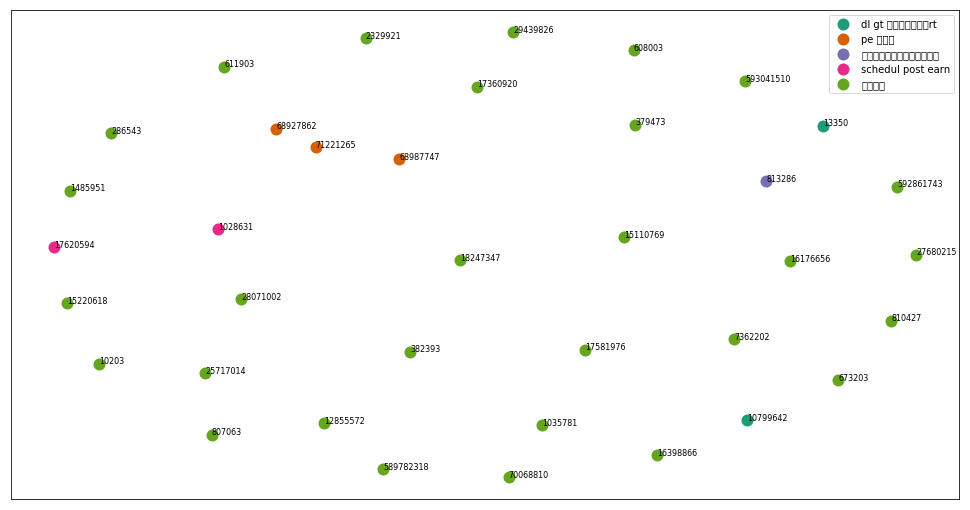

In [118]:

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)


## Trying it on my twitter download (from https://github.com/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb)

In [153]:

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
print(random.sample(stopwords, 10))

['why', 'most', 'under', 'a', "you'd", 'wouldn', 'didn', 'does', 'being', "shan't"]


In [154]:

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [155]:

def tokenize_and_stem(text):
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [221]:

import re
import os

tweet_text_list = []
tweet_id_list = []

grail_regex = re.compile(r'Grailbird\.data\.[^ ]+')
crlf_regex = re.compile(r'[\r\n]+')
false_regex = re.compile(r'false')
true_regex = re.compile(r'true')
user_regex = re.compile(r'@[^ ]+\s+')
url_regex = re.compile(r'\bhttps?:[^\s]+\s*')

tweets_folder = r'C:\Users\dev\Google Drive\dbabbitt_tweets\data\js\tweets\\'
for file_name in os.listdir(tweets_folder):
    if file_name.endswith('.js'):
        file_path = os.path.join(tweets_folder, file_name)
        tweet_str = open(file_path).read()
        tweet_str = grail_regex.sub('tweet_list', tweet_str, 1)
        tweet_str = crlf_regex.sub('', tweet_str)
        tweet_str = false_regex.sub('False', tweet_str)
        tweet_str = true_regex.sub('True', tweet_str)
        exec(tweet_str)
        
        for tweet_dict in tweet_list:
            tweet_text = tweet_dict['text']
            if not tweet_text.startswith('RT '):
                tweet_text = url_regex.sub('', tweet_text)
                tweet_text = crlf_regex.sub(' ', tweet_text)
                tweet_text = user_regex.sub('', tweet_text)
                if len(tweet_text) > 0:
                    tweet_text_list.append(tweet_text)
                    tweet_id = tweet_dict['id_str']
                    tweet_id_list.append(tweet_id)

In [222]:

# Use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
tweet_text_stemmed_list = []
for tweet_text in tweet_text_list:
    allwords_stemmed = tokenize_and_stem(tweet_text) #for each item in the tweet text list, tokenize/stem
    tweet_text_stemmed_list.append(' '.join(allwords_stemmed))
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(tweet_text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [223]:

print(len(tweet_text_list))
print(random.sample(tweet_text_list, 10))

1008
["Flipping off a reporter from the back of a police car: you can't teach that. (My son the admirable rascal.)", 'It will make for a healthier population. I could certainly use the incentive! :-)', 'Robot Race by Senbei is the theme song for Sam Charrington\'s "This Week in Machine Learning &amp; AI" podcast', 'Screenshot of running on Vesk in the Citrix Receiver running on my iPhone: ', 'Kentucky Wisteria; Arizona Babbitt; Pizza Hut ', 'They’ll grow up with even less empathy than their parents', "I'll have to test it on the 18 year old - he grew up with this stuff.", 'I still remember 2017 like it was yesterday', '1234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890', 'I now have 128 microwheatons on twitter.']


In [224]:

print(len(tweet_text_stemmed_list))
print(random.sample(tweet_text_stemmed_list, 10))

1008
['start github repositori of all my deep learn project take more coursera class', "i 'm get an unexpect constant error when i tri to access \\/cfide\\/administrator\\/index.cfm ani idea", 'when you vector a sequenc of word it allow you to do surpris simpl math like king man woman queen', 'java javascript actionscript coldfus job trend indeed.com java javascript actionscript coldfus j..', 'wow this site is take the edg off rant mode by make reader pass a quiz befor comment via niemanlab', 'all my cat doe is sleep nowaday', "here 's my pompous wordi inde resum", "and will to equality'—that itself shall henceforth be the name of virtu and against all that hath power will we rais an outcri", 'presid of the unit state declar antifa a terrorist organ sign the petit via chang', "havasupai has been flood by a earthen dam break my father was the tribe 's lawyer and i use to go down there a lot as a child"]


In [225]:

tweet_text

'I notice you\'ve tacked on another word after "rights" (which is hard enough to define) - you\'ve got "voices". How do you define that? What\'s the next word you\'ll tack on? How do you define "campaigning"? You\'re already down his finger-jiggling track towards "the worst sort".'

In [226]:

print(len(allwords_stemmed))
print(allwords_stemmed)

50
['i', 'notic', 'you', 've', 'tack', 'on', 'anoth', 'word', 'after', 'right', 'which', 'is', 'hard', 'enough', 'to', 'defin', 'you', 've', 'got', 'voic', 'how', 'do', 'you', 'defin', 'that', 'what', "'s", 'the', 'next', 'word', 'you', 'll', 'tack', 'on', 'how', 'do', 'you', 'defin', 'campaign', 'you', 're', 'alreadi', 'down', 'his', 'finger-jiggl', 'track', 'toward', 'the', 'worst', 'sort']


In [227]:

print(len(allwords_tokenized))
print(allwords_tokenized)

50
['i', 'notice', 'you', "'ve", 'tacked', 'on', 'another', 'word', 'after', 'rights', 'which', 'is', 'hard', 'enough', 'to', 'define', 'you', "'ve", 'got', 'voices', 'how', 'do', 'you', 'define', 'that', 'what', "'s", 'the', 'next', 'word', 'you', "'ll", 'tack', 'on', 'how', 'do', 'you', 'define', 'campaigning', 'you', "'re", 'already', 'down', 'his', 'finger-jiggling', 'track', 'towards', 'the', 'worst', 'sort']


In [228]:

print(len(totalvocab_stemmed))
print(random.sample(totalvocab_stemmed, 10))

15866
['in', 'victor', 'an', 'to', 'jonathan', 'upon', 'is', 'for', 'as', 'not']


In [229]:

print(len(totalvocab_tokenized))
print(random.sample(totalvocab_tokenized, 10))

15866
['apple', 'serious', 'i', 'racial', 'in', 'actionscript', 'can', 'this', 'have', 'history']


In [230]:

vocab_df = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
formatted_str = 'there are {:,} items in vocab_df'
print(formatted_str.format(vocab_df.shape[0]))

there are 15,866 items in vocab_df


In [234]:

vocab_df.sample(20).T

,competit,in,bald,level,you,and,you,a,appli,and,kind,hatr,can,free,that,is,instead,the,'m,busi
words,competition,in,bald,level,you,and,you,a,applied,and,kind,hatred,can,free,that,is,instead,the,'m,business


In [235]:

tweet_tfidf_matrix = tfidf_vectorizer.fit_transform(tweet_text_stemmed_list)

In [236]:

tweet_terms = tfidf_vectorizer.get_feature_names()
print(len(tweet_terms))
print(random.sample(tweet_terms, 10))

15383
['everi cool', 'constant error tri', 'project', 'imposs master', 'malevol betray', 'social justic warrior', 'attach ani', 'incent downsid', 'defend social capit', 'advanc incompet']


In [237]:

from sklearn.metrics.pairwise import cosine_similarity

tweet_dist = 1 - cosine_similarity(tweet_tfidf_matrix)
print(tweet_dist)

[[-2.22044605e-16  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00 -4.44089210e-16  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  9.82992148e-01]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ... -2.22044605e-16
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  9.82992148e-01  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  6.66133815e-16]]


In [238]:

from sklearn.cluster import KMeans

num_clusters = 5

tweet_km = KMeans(n_clusters=num_clusters)

%time tweet_km.fit(tweet_tfidf_matrix)

tweet_clusters = tweet_km.labels_.tolist()
print(len(tweet_clusters))
tweet_clusters[:10]

Wall time: 420 ms
1008


[0, 0, 4, 0, 4, 0, 4, 0, 0, 0]

In [239]:

data_dict = {'tweet_ids': tweet_id_list, 'tweet_texts': tweet_text_stemmed_list,
             'tweet_clusters': tweet_clusters}

tweet_clusters_df = pd.DataFrame(data_dict, index=[tweet_clusters],
                                 columns=['tweet_ids', 'tweet_texts', 'tweet_clusters'])

In [240]:

tweet_clusters_df['tweet_clusters'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    778
2     95
4     66
1     36
3     33
Name: tweet_clusters, dtype: int64

In [247]:

print("Top terms per cluster:")
print()

# Sort cluster centers by proximity to centroid
tweet_order_centroids = tweet_km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in tweet_order_centroids[i, :3]: #replace 6 with n words per cluster
        print(' %s' % vocab_df.loc[tweet_terms[ind]].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d tweet_ids:" % i, end='')
    for tweet_id in tweet_clusters_df.loc[i, 'tweet_ids'].values.tolist()[:3]:
        print(' %s,' % tweet_id, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: like, ophanocracy, just,

Cluster 0 tweet_ids: 9028351, 220082452, 780302708,

Cluster 1 words: time, remember, went,

Cluster 1 tweet_ids: 1088791083, 1445220368, 2418965650,

Cluster 2 words: need, ca, world,

Cluster 2 tweet_ids: 1038682120, 1222668866, 1181165686,

Cluster 3 words: trying, asking, url,

Cluster 3 tweet_ids: 969419185, 1115969785, 1188707377,

Cluster 4 words: work, looking, coldfusion,

Cluster 4 tweet_ids: 568866052, 780445582, 902270350,



In [242]:

tweet_terms[ind]

'look'

In [243]:

for ind in tweet_order_centroids[i, :6]:
    print(tweet_terms[ind].split(' '))

['work']
['look']
['coldfus']
['look', 'like']
['like']
['coldfus', 'work']


In [245]:

tweet_order_centroids

array([[ 7469,  9354,  6893, ..., 14834, 10380, 10786],
       [13598, 11119, 14830, ..., 10048, 10047,     0],
       [ 8844,  1732, 15165, ...,  9884,  9883,     0],
       [13827,   810, 14245, ..., 10092, 10091,     0],
       [15110,  7749,  2370, ..., 10012, 10011,     0]], dtype=int64)

In [246]:

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# Convert two components as we're plotting points in a two-dimensional plane
# precomputed because we provide a distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed')

pos = mds.fit_transform(tweet_dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [248]:

# Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# Set up cluster names using a dict
cluster_names = {0: 'like, ophanocracy, just',
                 1: 'time, remember, went',
                 2: 'need, ca, world',
                 3: 'trying, asking, url',
                 4: 'work, looking, coldfusion',}

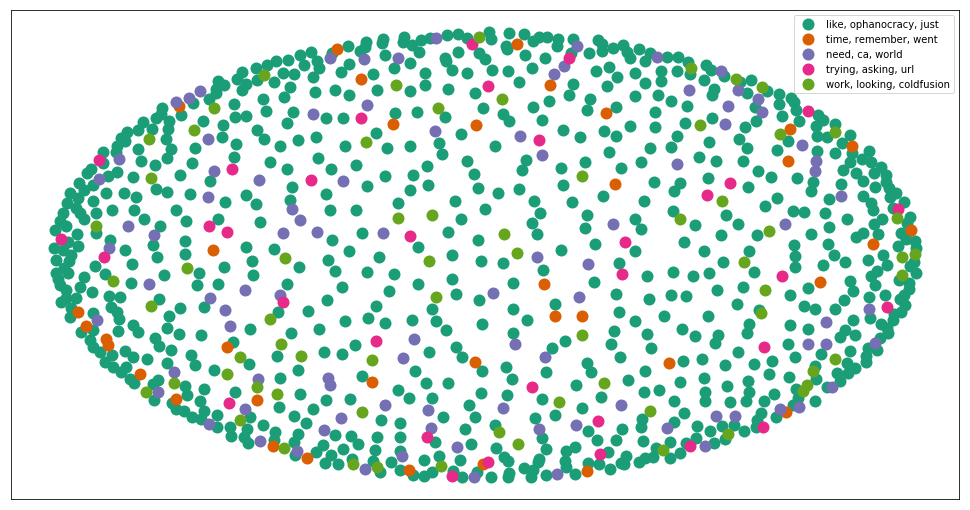

In [252]:

%matplotlib inline 

# Create data frame that has the result of the MDS plus the cluster numbers and tweet IDs
df = pd.DataFrame(dict(x=xs, y=ys, label=tweet_clusters, title=tweet_id_list)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
legend_obj = ax.legend(numpoints=1)  #show legend with only 1 point

In [254]:

print(type(tweet_tfidf_matrix))

<class 'scipy.sparse.csr.csr_matrix'>


In [258]:

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)

elite_ndarray = svd.fit_transform(tweet_tfidf_matrix)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.00359452 0.00166059]
0.005255105314884654
[1.9367536  1.72826305]


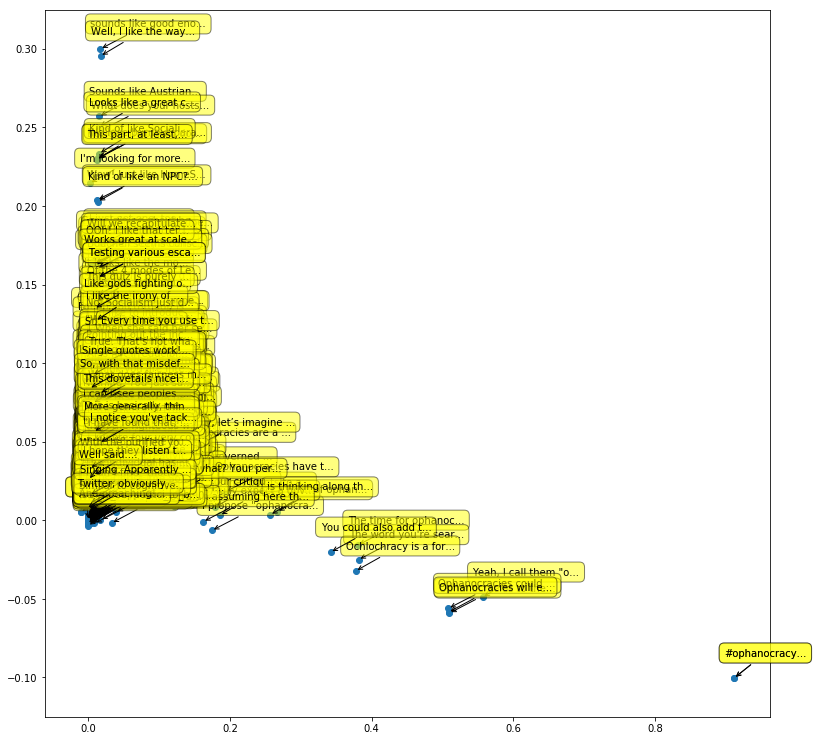

In [268]:

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')

path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1], cmap=cmap)

kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for label, x, y in zip(tweet_text_list, elite_ndarray[:, 0], elite_ndarray[:, 1]):
    annotation = plt.annotate(label[:20]+'...', xy=(x, y), xytext=(-10, 20), **kwargs)

In [264]:

print(len(tweet_text_list))
print(elite_ndarray.shape)

1008
(1008, 2)


In [265]:

ax.scatter?